# 03 — Feature Engineering: True 3PT%

## Ziel
In diesem Notebook wird eine bereinigte Drei-Punkte-Effizienzkennzahl (True 3PT%) entwickelt. Ziel ist es, die Schwächen der klassischen Drei-Punkte-Quote (3P%) auszugleichen, insbesondere bei sehr hohem oder sehr niedrigem Wurfvolumen. Dadurch sollen stabilere und besser vergleichbare Aussagen zur Drei-Punkte-Effizienz von Teams über verschiedene Saisons hinweg ermöglicht werden.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

df = pd.read_csv(
    "/content/nba_master_all_seasons_sorted.csv",
    sep=";",
    decimal=",",
    engine="python"
)

# Prozentspalten sicher numerisch
pct_cols = ["FG%", "3P%", "FT%"]
for c in pct_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ".", regex=False), errors="coerce")

df.head()

Saving nba_master_all_seasons_sorted.csv to nba_master_all_seasons_sorted.csv


,gameid,date,type,teamid,team,home,away,MIN,PTS,FGM,...,DREB,REB,AST,TOV,STL,BLK,PF,+/-,win,season
0,29600001,35370,regular,1610612738,BOS,BOS,CHI,48,98,38,...,22,36,20,18.0,10,2,33,-9.0,0,1997
1,29600001,35370,regular,1610612741,CHI,BOS,CHI,48,107,42,...,29,37,28,19.0,7,8,23,9.0,1,1997
2,29600002,35370,regular,1610612739,CLE,NJN,CLE,48,90,34,...,23,35,16,15.0,11,1,24,13.0,1,1997
3,29600002,35370,regular,1610612751,NJN,NJN,CLE,48,77,23,...,24,35,13,22.0,7,7,19,-13.0,0,1997
4,29600003,35370,regular,1610612749,MIL,PHI,MIL,48,111,38,...,31,50,21,15.0,9,7,30,8.0,1,1997


## Gruppierung auf Team × Saison

Da Effizienzkennzahlen auf stabilen Stichproben basieren sollten,
werden die Team-Spiel-Daten zunächst auf Team × Saison gruppiert.

In [10]:
season_team = (
    df.groupby(["season", "teamid", "team"])
      .agg(
          games=("gameid", "nunique"),
          three_pm=("3PM", "sum"),
          three_pa=("3PA", "sum")
      )
      .reset_index()
)

season_team["3P_pct"] = season_team["three_pm"] / season_team["three_pa"]
season_team.head()

,season,teamid,team,games,three_pm,three_pa,3P_pct
0,1997,1610612737,ATL,92,728,2052,0.354776
1,1997,1610612738,BOS,82,467,1331,0.350864
2,1997,1610612739,CLE,82,483,1284,0.376168
3,1997,1610612741,CHI,101,639,1767,0.361630
4,1997,1610612742,DAL,82,429,1315,0.326236


## Motivation für True 3PT%

Die klassische 3P% berücksichtigt das Wurfvolumen (Attempts) nicht.
Teams mit wenigen Versuchen können extreme Quoten aufweisen,
während Teams mit hohem Volumen automatisch stärker zur Mitte tendieren.

Daher wird eine Bayes-ähnliche Anpassung verwendet, die extreme Werte
in Richtung Ligadurchschnitt zieht, damit Teams mit niedrigerem Volumen das Endergebnis nicht verzerren.

In [11]:
league_3p_pct = season_team["three_pm"].sum() / season_team["three_pa"].sum()
prior_weight = 500  # Stärke des Priors (≈ 500 Dreier)

league_3p_pct

np.float64(0.35710828016923796)

In [12]:
season_team["true_3P_pct"] = (
    season_team["three_pm"] + prior_weight * league_3p_pct
) / (
    season_team["three_pa"] + prior_weight
)

season_team[["3P_pct", "true_3P_pct"]].describe()

,3P_pct,true_3P_pct
count,863.000000,863.000000
mean,0.354444,0.355632
std,0.019499,0.014314
min,0.259341,0.307320
25%,0.342757,0.346247
50%,0.354592,0.355109
75%,0.367434,0.365112
max,0.425680,0.407943


## Vergleich: 3P% vs. True 3PT%

Im Folgenden wird die klassische Drei-Punkte-Quote mit der
volumenbereinigten True 3PT% verglichen.

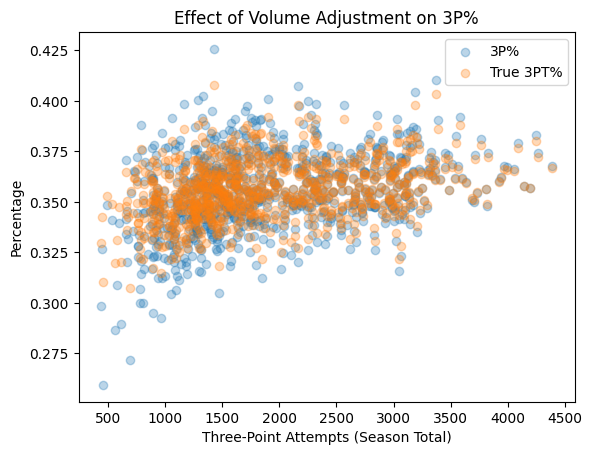

In [13]:
plt.figure()
plt.scatter(season_team["three_pa"], season_team["3P_pct"], alpha=0.3, label="3P%")
plt.scatter(season_team["three_pa"], season_team["true_3P_pct"], alpha=0.3, label="True 3PT%")
plt.xlabel("Three-Point Attempts (Season Total)")
plt.ylabel("Percentage")
plt.legend()
plt.title("Effect of Volume Adjustment on 3P%")
plt.show()

Die True 3PT% gleicht Verzerrungen aus, die bei der normalen 3P% besonders dann auftreten, wenn nur wenige Würfe genommen werden. Extreme Trefferquoten werden dabei weniger stark überbewertet, während Teams mit hohem Wurfvolumen insgesamt stabilere und verlässlichere Effizienzwerten erhalten. Dadurch eignet sich die Kennzahl besser für Vergleiche zwischen verschiedenen Saisons und kann gleichzeitig als sinnvoller Input für weiterführende statistische Analysen und Hypothesentests genutzt werden.

## Zeitliche Entwicklung: 3P% vs. True 3PT%

Das Liniendiagramm vergleicht die klassische Drei-Punkte-Quote mit der
volumenbereinigten True 3PT% auf Ligaebene über die Zeit. Man kann über die Jahre eine klare Entwicklung der 3PT% erkennen, wobei True hierbei das Verhältnis zum Ligadurchschnitt zeigt was zu deutlich weniger Ausreißern führt.

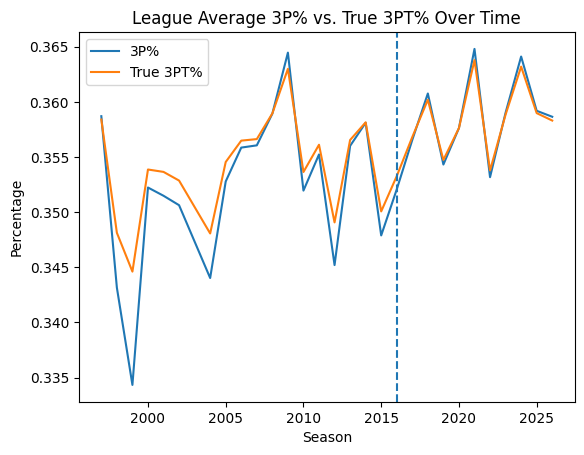

In [14]:
# Ligenweite Entwicklung: klassische 3P% vs. True 3PT%
league_true_trend = (
    season_team.groupby("season")
    .agg(
        avg_3P_pct=("3P_pct", "mean"),
        avg_true_3P_pct=("true_3P_pct", "mean")
    )
    .reset_index()
)

plt.figure()
plt.plot(league_true_trend["season"], league_true_trend["avg_3P_pct"], label="3P%")
plt.plot(league_true_trend["season"], league_true_trend["avg_true_3P_pct"], label="True 3PT%")
plt.axvline(2016, linestyle="--")  # Beginn moderne 3PT-Ära
plt.xlabel("Season")
plt.ylabel("Percentage")
plt.title("League Average 3P% vs. True 3PT% Over Time")
plt.legend()
plt.show()